In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.formula.api as smf
matplotlib.style.use('ggplot')
%matplotlib inline

# Load the data on income and wealth
income_and_wealth = pd.read_excel('data/zh-income-wealth.xlsx')
income_and_wealth.rename(columns={'BFS_NR': 'municipality', 'GEBIET_NAME': 'municipality_name', 'INDIKATOR_JAHR': 'year'}, inplace=True)

# Pick out the series we are interested in : median income and median wealth
income_and_wealth_grouped = income_and_wealth.groupby('INDIKATOR_ID')
median_income = income_and_wealth_grouped.get_group(316).rename(columns={'INDIKATOR_VALUE' : 'income'})
median_wealth = income_and_wealth_grouped.get_group(320).rename(columns={'INDIKATOR_VALUE' : 'wealth'})

# Discard the columns we do not care about
median_income = median_income[['municipality', 'year', 'municipality_name', 'income']]
median_wealth = median_wealth[['municipality', 'year', 'wealth']]
median_income_and_wealth = median_income.merge(median_wealth, on=['municipality', 'year'], how="left")

# Load the data on voting
votes = pd.read_csv('data/2015-06-elections-partystrengths/analysis/output/partystrengths.csv')
parties = pd.read_csv('data/2015-06-elections-partystrengths/analysis/output/parties.csv')
parties.rename(columns={'ID': 'party', 'Abbr_D': 'party_name'}, inplace=True)
parties = parties[['party', 'party_name']]

# Create a frame that merges income data with voting
df = median_income_and_wealth.merge(votes,
    on=['municipality', 'year'], how='inner').merge(parties,
    on='party', how='left')

In [30]:
df.head()

,municipality,year,municipality_name,income,wealth,party,support,party_name
0,1,1999,Aeugst a.A.,47700,NaN,1,0.247092,FDP
1,1,1999,Aeugst a.A.,47700,NaN,2,0.025894,CVP
2,1,1999,Aeugst a.A.,47700,NaN,3,0.252853,SP
3,1,1999,Aeugst a.A.,47700,NaN,4,0.296906,SVP
4,1,1999,Aeugst a.A.,47700,NaN,7,0.014428,EVP


In [31]:
# Compute z-scores for income and party support for easier comparibility accross times
zscore = lambda x: (x - x.mean()) / x.std()
df['z_income'] = pd.Series(df.groupby(['year'])['income'].transform(zscore), index=df.index)
df['z_wealth'] = pd.Series(df.groupby(['year'])['wealth'].transform(zscore), index=df.index)
df['z_support'] = pd.Series(df.groupby(['year', 'party'])['support'].transform(zscore), index=df.index)

In [32]:
df.head()

,municipality,year,municipality_name,income,wealth,party,support,party_name,z_income,z_wealth,z_support
0,1,1999,Aeugst a.A.,47700,NaN,1,0.247092,FDP,0.31947,NaN,1.245728
1,1,1999,Aeugst a.A.,47700,NaN,2,0.025894,CVP,0.31947,NaN,-0.641184
2,1,1999,Aeugst a.A.,47700,NaN,3,0.252853,SP,0.31947,NaN,1.033298
3,1,1999,Aeugst a.A.,47700,NaN,4,0.296906,SVP,0.31947,NaN,-1.285255
4,1,1999,Aeugst a.A.,47700,NaN,7,0.014428,EVP,0.31947,NaN,-1.155562


In [66]:
def plot_relationship(party, variable, ax):
    # Get the data for the party/year
    data = df.groupby('party_name').get_group(party)
    # Filter out NaNs
    data = data[np.isfinite(data[variable])]
    # Create a model
    formula = 'z_support ~ {}'.format(variable)
    lm = smf.ols(formula=formula, data=data).fit()
    preds_input = pd.DataFrame({variable: [data[variable].min(), data[variable].max()]})
    preds = lm.predict(preds_input)
    # Plot the data
    data.plot(x=variable, y='z_support', kind='scatter', ax=ax)
    # Plot the model
    ax.plot(preds_input, preds, c='red', linewidth=2)
    
def plot_relationships(party):
    fig, axs = plt.subplots(1,2, sharey=True)
    plot_relationship(party, 'z_income', axs[0])
    plot_relationship(party, 'z_wealth', axs[1])
    fig.suptitle(party + ' support by income and wealth', fontsize=16)

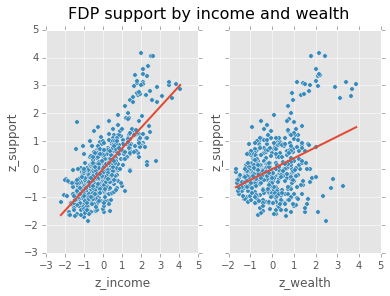

In [67]:
plot_relationships('FDP')

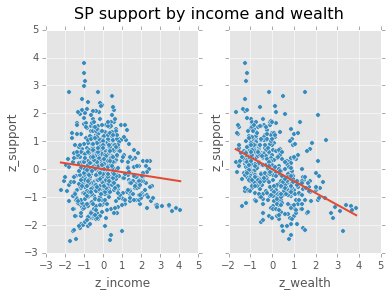

In [68]:
plot_relationships('SP')

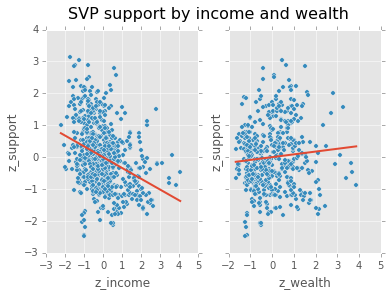

In [69]:
plot_relationships('SVP')

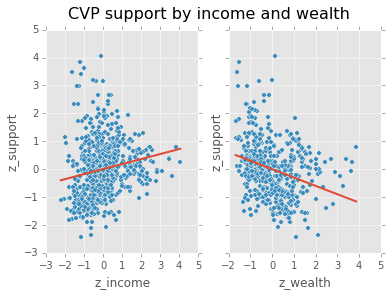

In [70]:
plot_relationships('CVP')

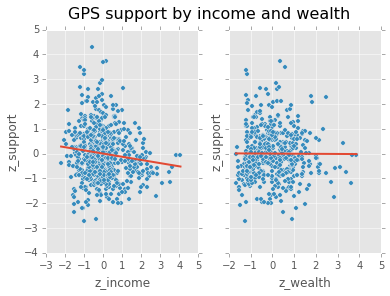

In [71]:
plot_relationships('GPS')

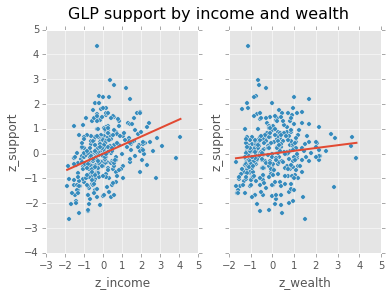

In [72]:
plot_relationships('GLP')